In [1]:
%cd ..

/home/jovyan/work/spectrum/c_final/v1


In [2]:
import pandas as pd
import base
import os
import re

2024-02-27 09:31:08.767253: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-27 09:31:08.801978: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 09:31:08.802013: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 09:31:08.802929: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 09:31:08.808753: I tensorflow/core/platform/cpu_feature_guar

In [3]:
SEED = 42
base.fix_seed(SEED)

desired_directory = '/home/jovyan/work/spectrum/'
os.chdir(desired_directory)

In [4]:
df_neg_ok_data2 = pd.read_csv('Data/02_basedata/neg/neg2.csv')

In [4]:
df = pd.read_csv('Data/02_basedata/df.csv')
df_neg = df[df['Adducttype'].str.contains('\]\-') | df['Adducttype'].str.contains('\]2\-')].drop('Unnamed: 0', axis=1)
df_neg_select = df_neg.merge(df_neg_ok_data2[['Metabolitename', 'dataset', 'AlignmentID']].reset_index().rename(columns={'index':'index_ID'}),
                             on=['Metabolitename', 'dataset', 'AlignmentID'])

".ms" fileの作成

In [ ]:
invalid_chars = r'[\\/:*?"<>|]'

for i in range(len(df_neg_select)):
    compound = df_neg_select['Metabolitename'][i]
    formula = df_neg_select['Formula'][i]
    parentmass = df_neg_select['AverageMz'][i]
    ionization = df_neg_select['Adducttype'][i]
    
    ms2_data = df_neg_select['MSMSspectrum'][i]
    elements = ms2_data.split()  
    id = df_neg_select.index.tolist()[i]
    metabolite = re.sub(invalid_chars, '_', df_neg_select['Metabolitename'][i])
    ontology = re.sub(invalid_chars, '_', df_neg_select['Ontology'][i])
    name_ont = f"{id}_{metabolite}_{ontology}"

    ms2_split_data = []
    for element in elements:
        parts = element.split(':')
        ms2_split_data.append(f"{parts[0]} {parts[1]}")

    output_file = f"Data/04_canopus/neg/ms2_spectrum_ms_neg3/{name_ont}.ms"
    with open(output_file, 'w', newline='') as file:
        
        file.write(f">compound {metabolite}_{ontology}\n")
        file.write(f">formula {formula}\n")
        file.write(f">parentmass {parentmass}\n")
        file.write(f">ionization {ionization}\n")
        
        file.write(">ms2\n")
        file.write('\n'.join(ms2_split_data)) 

In [ ]:
import zipfile
import os
import re

folder_path = 'Data/04_canopus/neg/s2_spectrum_ms_neg3'
zip_filename = 'Data/04_canopus/neg/ms2_spectrum_ms_neg3.zip'

with zipfile.ZipFile(zip_filename, 'w') as zipf:
    for foldername, subfolders, filenames in os.walk(folder_path):
        for filename in filenames:
            if filename.endswith('.ms'):
                file_path = os.path.join(foldername, filename)
                arcname = os.path.relpath(file_path, folder_path)
                zipf.write(file_path, arcname)

Import::7918/8163

canopusでの予測結果の読み込み

In [5]:
df_canopus = pd.read_csv('Data/04_canopus/neg/canopus_compound_summary_neg2.tsv', sep="\t")
df_canopus['index_id'] = df_canopus['id'].apply(lambda x: x.split("_")[1])
df_canopus_ = df_canopus[['id','ClassyFire#subclass','ClassyFire#level 5','index_id']]
df_canopus_['index_id'] = df_canopus_['index_id'].astype(int)

/tmp/ipykernel_949183/3286587303.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_canopus_['index_id'] = df_canopus_['index_id'].astype(int)


使うサブクラスの選択

In [7]:
select_ont = pd.read_csv('Data/04_canopus/neg/subclass_ont_select_neg.csv')

df_ytest = pd.read_csv('Data/04_canopus/neg/df_neg_ytest.csv').rename(columns={'Unnamed: 0':'index_ID'})
df_ytest = df_ytest[df_ytest['Ontology'].isin(select_ont.Ontology.tolist())].merge(select_ont, how='left', on='Ontology')

In [8]:
df_neg_select2 = df_neg_select.reset_index()[['index','index_ID']].rename(columns={'index':'index_id'}).astype(int)
df_model_canopus = df_neg_select2.merge(df_ytest, how='right', on='index_ID').merge(df_canopus_, how='left', on='index_id').\
drop(columns='index_id').sort_values('index_ID')

サブクラスごとの正答数を整理

In [9]:
subclasslist = ['Glycerophosphoethanolamines',
 'Glycerophosphocholines',
 'Ceramides',
 'Glycerophosphoinositols',
 'Glycerophosphoglycerols',
 'Glycerophosphoserines',
 'Phosphosphingolipids',
 'Fatty acids and conjugates']

df_neg_cano_class_pred = pd.DataFrame(columns=['Subclass','total', 'canopus_export','canopus_corpred', 'canopus_midpred'])

for i in subclasslist:
    df_model_canopus_i = df_model_canopus[df_model_canopus['subclass'] == i]
    export_number = len(df_model_canopus_i) - len(df_model_canopus_i[df_model_canopus_i['ClassyFire#subclass'].isna()])
    correct_predictions = len(df_model_canopus_i[df_model_canopus_i['ClassyFire#subclass'] == i])
    mispred_number = export_number - correct_predictions
    total_samples = len(df_model_canopus_i)

    new_row = {'Subclass': i,
               'total':total_samples,
               'canopus_export': export_number,
               'canopus_corpred': correct_predictions,
               'canopus_midpred': mispred_number}
    
    df_neg_cano_class_pred = pd.concat([df_neg_cano_class_pred, pd.DataFrame([new_row])], ignore_index=True)
    
df_neg_cano_class_pred.to_csv('Data/04_canopus/neg/df_neg_canopus_subclass_pred.csv', index=False)

モデルの予測結果と並べる

In [10]:
df_neg_model_subclass_pred = pd.read_csv('Data/04_canopus/neg/df_neg_subclass_pred.csv')

nanを消して、モデルと比較

In [12]:
df_neg_model_subclass_pred_ont = pd.read_csv('Data/04_canopus/neg/df_neg_subclass_pred_ont.csv')

In [13]:
df = df_model_canopus[['index_ID','Ontology','subclass','ClassyFire#subclass', 'id']].rename(columns={'ClassyFire#subclass':'canopus_pred'}).dropna(subset=['id']).\
merge(df_neg_model_subclass_pred_ont[['index','pred_subclass','pred_1class']].rename(columns={'index':'index_ID', 'pred_subclass':'model_pred'}), how='inner', on='index_ID').\
    drop(columns=['Ontology','id','pred_1class'])

In [14]:
df_model_canopus[['index_ID','Ontology','subclass','ClassyFire#subclass', 'id']].rename(columns={'ClassyFire#subclass':'canopus_pred'}).dropna(subset=['id']).\
merge(df_neg_model_subclass_pred_ont[['index','pred_subclass','pred_1class']].rename(columns={'index':'index_ID', 'pred_subclass':'model_pred'}), how='inner', on='index_ID').\
reset_index().rename(columns={'index':'index_id','pred_1class':'model_predclass'})[['index_id','Ontology','subclass','canopus_pred','model_pred','model_predclass']].to_csv('Data/04_canopus/neg/neg_canopus_model_pred_subclass.csv', index=False)

In [17]:
from sklearn.metrics import classification_report

canopus_report = classification_report(df['subclass'], df['canopus_pred'], output_dict=True)
model_report = classification_report(df['subclass'], df['model_pred'], output_dict=True)

excel_file = 'Data/04_canopus/classification_reports_neg.xlsx'
with pd.ExcelWriter(excel_file, engine='openpyxl') as writer:
    pd.DataFrame(canopus_report).transpose().to_excel(writer, sheet_name='Canopus Report')
    pd.DataFrame(model_report).transpose().to_excel(writer, sheet_name='Model Report')

/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


canopusで予測できなかったものを含めて描画

In [20]:
df = df_model_canopus[['index_ID','Ontology','subclass','ClassyFire#subclass', 'id']].rename(columns={'ClassyFire#subclass':'canopus_pred'}).\
merge(df_neg_model_subclass_pred_ont[['index','pred_subclass','pred_1class']].rename(columns={'index':'index_ID', 'pred_subclass':'model_pred'}), how='inner', on='index_ID').\
    drop(columns=['Ontology','id','pred_1class'])

In [22]:
subclasslist = ['Glycerophosphoethanolamines',
 'Glycerophosphocholines',
 'Ceramides',
 'Glycerophosphoinositols',
 'Glycerophosphoglycerols',
 'Glycerophosphoserines',
 'Phosphosphingolipids',
 'Fatty acids and conjugates']

df_neg_cano_class_pred = pd.DataFrame(columns=['Subclass','total', 'model_correct','model_mis', 'canopus_correct','canopus_mis','canopus_nan'])

for i in subclasslist:
    dfi = df[df['subclass'] == i]
    total = len(dfi)
    model_correct = len(dfi[dfi['model_pred'] == i])
    model_mis = len(dfi[dfi['model_pred'] != i])
    canopus_correct = len(dfi[dfi['canopus_pred'] == i])
    canopus_nan = len(dfi[dfi['canopus_pred'].isna()])
    canopus_mis = total - canopus_correct - canopus_nan

    new_row = {'Subclass': i,
               'total':total,
               'model_correct': model_correct,
               'model_mis': model_mis,
               'canopus_correct': canopus_correct,
               'canopus_mis':canopus_mis,
               'canopus_nan':canopus_nan}
    
    df_neg_cano_class_pred = pd.concat([df_neg_cano_class_pred, pd.DataFrame([new_row])], ignore_index=True)
    
df_neg_cano_class_pred.to_csv('Data/04_canopus/neg/df_neg_subclass_pred.csv', index=False)

In [24]:
df_all = df_neg_cano_class_pred.rename(columns={'Subclass':'class'}).set_index('class')

df_all_2 = pd.DataFrame()
df_all_2['model_correct'] = (df_all['model_correct']/df_all['total'])*100
df_all_2['model_mispred'] = 100-df_all_2['model_correct']

df_all_2['canopus_correct'] = (df_all['canopus_correct']/df_all['total'])*100
df_all_2['canopus_mispred'] = (df_all['canopus_mis']/df_all['total'])*100
df_all_2['canopus_nonpred'] = (df_all['canopus_nan']/df_all['total'])*100
df_all_2

,model_correct,model_mispred,canopus_correct,canopus_mispred,canopus_nonpred
class,,,,,
Glycerophosphoethanolamines,100.0,0.0,62.530414,7.785888,29.683698
Glycerophosphocholines,99.760192,0.239808,50.119904,1.438849,48.441247
Ceramides,100.0,0.0,79.381443,0.0,20.618557
Glycerophosphoinositols,100.0,0.0,48.322148,0.0,51.677852
Glycerophosphoglycerols,97.333333,2.666667,62.666667,0.0,37.333333
Glycerophosphoserines,97.468354,2.531646,88.607595,1.265823,10.126582
Phosphosphingolipids,100.0,0.0,44.086022,0.0,55.913978
Fatty acids and conjugates,90.909091,9.090909,9.090909,54.545455,36.363636


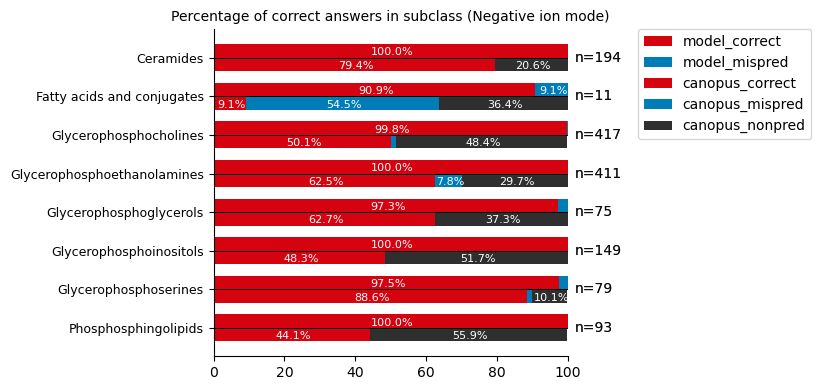

In [26]:
import matplotlib.pyplot as plt
import numpy as np

df_all2 = df_all_2.reset_index().sort_values('class')

# Create a bar chart for model data
fig, ax = plt.subplots(figsize=(9, 4))

width = 0.35  # Width of each bar

y = np.arange(len(df_all2['class']))

red = '#d50310'
blue = '#007cb6'
black = '#2f2f2f'
custom_colors = [red, blue, black]

# Plot model_1st_correct and model_mispredict bars
ax.barh(y - width/2, df_all2['model_correct'], width, label='model_correct', color=custom_colors[0])
ax.barh(y - width/2, df_all2['model_mispred'], width, label='model_mispred', color=custom_colors[1], left=df_all2['model_correct'])
ax.barh(y + width/2, df_all2['canopus_correct'], width, label='canopus_correct', color=custom_colors[0])
ax.barh(y + width/2, df_all2['canopus_mispred'], width, label='canopus_mispred', color=custom_colors[1], left=df_all2['canopus_correct'])
ax.barh(y + width/2, df_all2['canopus_nonpred'], width, label='canopus_nonpred', color=custom_colors[2], left=df_all2['canopus_correct'] + df_all2['canopus_mispred'])

#ax.set_ylabel('Class', fontsize=10)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Percentage of correct answers in subclass (Negative ion mode)', fontsize=10)
ax.set_yticks(y)
ax.set_yticklabels(df_all2['class'], fontsize=10)
ax.legend(loc='upper left', bbox_to_anchor=(1.2, 1))

bars1= df_all2[['model_correct','model_mispred']]
bars2= df_all2[['canopus_correct','canopus_mispred','canopus_nonpred']]

  
for n in bars1:
    for i, (cs, ab, pc, sn) in enumerate(zip(bars1.iloc[:, 0:].cumsum(1)[n],
                                          bars1[n], bars1[n],df_all.sort_index()['total'])):
        if pc > 5.0:  
            plt.text(cs - ab / 2 + 0.5, i - width/2 + 0.04, str(np.round(pc, 1)) + '%',
                     va='center', ha='center', rotation=0, fontsize=8, c='white')
        plt.text(100 + 2, i, f'n={sn}', va='center', ha='left', fontsize=10, alpha=0.8, c='black')
        #plt.text(100 + 2, i+0.2, f'{sn2}', va='center', ha='left', fontsize=8, alpha=0.8)

for n in bars2:
    for i, (cs, ab, pc) in enumerate(zip(bars2.iloc[:, 0:].cumsum(1)[n],
                                          bars2[n], bars2[n])):
        if pc > 5.0:  
            plt.text(cs - ab / 2 + 0.5, i + width/2 + 0.04, str(np.round(pc, 1)) + '%',
                     va='center', ha='center', rotation=0, fontsize=8, c='white')
            

for i in range(len(df_all2)):
    plt.axhline(i, color='black', linewidth=0.7)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.gca().invert_yaxis()

#plt.legend().set_visible(False)
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0., ncol = 1)
plt.yticks(size = 9)
plt.tight_layout()
plt.savefig('Data/svg/test/canopus/neg_canopus-vs-model_subclass.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()

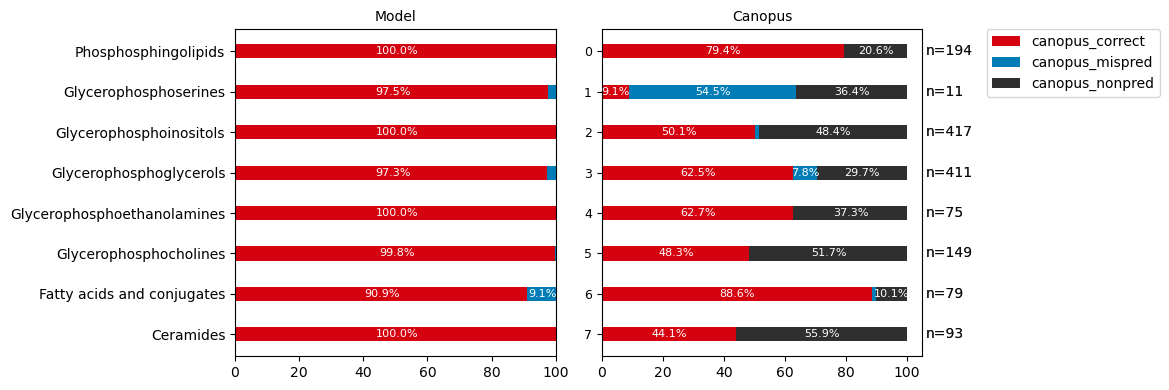

In [48]:
import matplotlib.pyplot as plt
import numpy as np

df_all2 = df_all_2.reset_index().sort_values('class')

# Create a bar chart for model data
fig, ax = plt.subplots(1,2,figsize=(12, 4))

width = 0.35  # Width of each bar

y = np.arange(len(df_all2['class']))

red = '#d50310'
blue = '#007cb6'
black = '#2f2f2f'
custom_colors = [red, blue, black]

# Plot model_1st_correct and model_mispredict bars
ax[0].barh(y, df_all2['model_correct'], width, label='model_correct', color=custom_colors[0])
ax[0].barh(y, df_all2['model_mispred'], width, label='model_mispred', color=custom_colors[1], left=df_all2['model_correct'])
ax[1].barh(y, df_all2['canopus_correct'], width, label='canopus_correct', color=custom_colors[0])
ax[1].barh(y, df_all2['canopus_mispred'], width, label='canopus_mispred', color=custom_colors[1], left=df_all2['canopus_correct'])
ax[1].barh(y, df_all2['canopus_nonpred'], width, label='canopus_nonpred', color=custom_colors[2], left=df_all2['canopus_correct'] + df_all2['canopus_mispred'])

#ax.set_ylabel('Class', fontsize=10)
ax[0].set_xlabel('')
ax[1].set_xlabel('')
ax[0].set_ylabel('')

ax[0].set_title('Model', fontsize=10)
ax[1].set_title('Canopus', fontsize=10)

ax[0].set_yticks(y)
ax[0].set_yticklabels(df_all2['class'], fontsize=10)
ax[1].legend(loc='upper left', bbox_to_anchor=(1.2, 1))

bars1= df_all2[['model_correct','model_mispred']]
bars2= df_all2[['canopus_correct','canopus_mispred','canopus_nonpred']]

# Text annotations for bars1 (ax[0])
for n in bars1:
    for i, (cs, ab, pc, sn) in enumerate(zip(bars1.iloc[:, 0:].cumsum(1)[n],
                                          bars1[n], bars1[n],df_all.sort_index()['total'])):
        if pc > 5.0:  
            ax[0].text(cs - ab / 2 + 0.5, i, str(np.round(pc, 1)) + '%',
                     va='center', ha='center', rotation=0, fontsize=8, c='white')
        ax[1].text(100 + 6, i, f'n={sn}', va='center', ha='left', fontsize=10, alpha=0.8, c='black')

# Text annotations for bars2 (ax[1])
for n in bars2:
    for i, (cs, ab, pc) in enumerate(zip(bars2.iloc[:, 0:].cumsum(1)[n],
                                          bars2[n], bars2[n])):
        if pc > 5.0:  
            ax[1].text(cs - ab / 2 + 0.1, i, str(np.round(pc, 1)) + '%',
                     va='center', ha='center', rotation=0, fontsize=8, c='white')


# Invert the y-axis to have the classes ordered from top to bottom
plt.gca().invert_yaxis()

# Display the legend and the plot
plt.legend(bbox_to_anchor=(1.2, 1), loc=2, borderaxespad=0., ncol = 1)
plt.yticks(size = 9)
plt.tight_layout()


plt.show()

level5での正答率

In [70]:
df_model_canopus_level5 = df_model_canopus[['ClassyFire#subclass','ClassyFire#level 5']].drop_duplicates().dropna().sort_values('ClassyFire#subclass')

subclasslist = pd.DataFrame(df_model_canopus_level5['ClassyFire#subclass'].value_counts()).reset_index().query('count > 1')['ClassyFire#subclass'].tolist()

リゾ体との区別ができる PC/PE/PG/PS/PI だけを選択

In [79]:
df_model_canopus_level5_s = df_model_canopus[df_model_canopus['subclass'].\
isin(['Glycerophosphoglycerols','Glycerophosphocholines','Glycerophosphoethanolamines','Glycerophosphoinositols','Glycerophosphoserines'])]
df_model_canopus_level5_s = df_model_canopus_level5_s[~df_model_canopus_level5_s['Ontology'].isin(['HBMP','LNAPE'])]

In [80]:
level5_to_class_dict = {
'1-alkyl,2-acylglycero-3-phosphocholines':'PC',
'Lysophosphatidylcholines':'LPC',
'1-(1Z-alkenyl),2-acyl-glycerophosphocholines':'PC',
'Phosphatidylcholines':'PC',
'Phosphatidylethanolamines':'PE',
'1-(1Z-alkenyl),2-acylglycerophosphoethanolamines':'PE',
'Lysophosphatidylglycerols':'LPG',
'Phosphatidylglycerols':'PG',
'Lysophosphatidylinositols':'LPI',
'Phosphatidylinositols':'PI',
'Lysophosphatidylserines':'LPS',
'Phosphatidylserines':'PS'
}

df_model_canopus_level5_s['level5_to_class'] = df_model_canopus_level5_s['ClassyFire#level 5'].map(level5_to_class_dict)
df_model_canopus_level5_s['ontology_to_class'] = df_model_canopus_level5_s['Ontology'].str.replace('Ether', '')

In [81]:
df_model_ont = pd.read_csv('Data/04_canopus/neg/df_neg_subclass_pred_ont.csv').rename(columns={'index':'index_ID'})[['index_ID','pred_ont']]

In [109]:
df_model_canopus_level5_s2 = df_model_canopus_level5_s.merge(df_model_ont, how='inner', on='index_ID')

In [163]:
df_model_canopus_level5_s2_cano = pd.DataFrame(df_model_canopus_level5_s2[['ontology_to_class','level5_to_class']].fillna('NA').value_counts()).reset_index().sort_values('ontology_to_class')
df_model_canopus_level5_s2_model = pd.DataFrame(df_model_canopus_level5_s2[['ontology_to_class','pred_ont']].fillna('NA').value_counts()).reset_index().sort_values('ontology_to_class')

df_model_canopus_level5_s2_model['pred_ont'] = df_model_canopus_level5_s2_model['pred_ont'].str.replace('Ether', '')

In [169]:
print(df_model_canopus_level5_s2_model[df_model_canopus_level5_s2_model['ontology_to_class'] == df_model_canopus_level5_s2_model['pred_ont']][['count']].sum())
print(df_model_canopus_level5_s2_cano[df_model_canopus_level5_s2_cano['ontology_to_class'] == df_model_canopus_level5_s2_cano['level5_to_class']][['count']].sum())

count    1121
dtype: int64
count    636
dtype: int64


In [170]:
636/651

0.9769585253456221

In [222]:
import pandas as pd

classlist = df_model_canopus_level5_s2['ontology_to_class'].drop_duplicates().tolist()
df_model_canopus_level5_s2_cano_result = pd.DataFrame(columns=['class', 'correct_pred', 'non_pred', 'mis_pred', 'total_number'])

for i in classlist:
    df_model_canopus_level5_s2_i = df_model_canopus_level5_s2_cano[df_model_canopus_level5_s2_cano['ontology_to_class'] == i]
    
    if not df_model_canopus_level5_s2_i.empty:  # DataFrameが空でないことを確認
        correct_pred_values = df_model_canopus_level5_s2_i[df_model_canopus_level5_s2_i['level5_to_class'] == i]['count'].values
        non_pred_values = df_model_canopus_level5_s2_i[df_model_canopus_level5_s2_i['level5_to_class'] == "NA"]['count'].values
        mis_pred_values = df_model_canopus_level5_s2_i[~df_model_canopus_level5_s2_i['level5_to_class'].isin([i, "NA"])]['count'].values
      
        if len(correct_pred_values) > 0:
            correct_pred = correct_pred_values[0]
        else:
            correct_pred = 0

        if len(non_pred_values) > 0:
            non_pred = non_pred_values[0]
        else:
            non_pred = 0

        if len(mis_pred_values) > 0:
            mis_pred = mis_pred_values[0]
        else:
            mis_pred = 0

        number = df_model_canopus_level5_s2_i[['count']].sum().astype(int).values[0]

        df_model_canopus_level5_s2_cano_result = pd.concat([df_model_canopus_level5_s2_cano_result,\
                                                       pd.DataFrame({'class': [i], 'correct_pred': [correct_pred], 'non_pred': [non_pred], 'mis_pred': [mis_pred], 'total_number': [number]})])

df_model_canopus_level5_s2_cano_result = df_model_canopus_level5_s2_cano_result.reset_index(drop=True)

df_model_canopus_level5_s2_cano_resultratio = df_model_canopus_level5_s2_cano_result.copy()
df_model_canopus_level5_s2_cano_resultratio['subclass'] = ['Glycerophosphocholines','Glycerophosphoethanolamines','Glycerophosphoglycerols','Glycerophosphoinositols','Glycerophosphoserines','Glycerophosphocholines','Glycerophosphoethanolamines','Glycerophosphoglycerols','Glycerophosphoinositols','Glycerophosphoserines']
df_model_canopus_level5_s2_cano_resultratio['correct_pred'] = df_model_canopus_level5_s2_cano_resultratio['correct_pred'] / df_model_canopus_level5_s2_cano_resultratio['total_number']
df_model_canopus_level5_s2_cano_resultratio['non_pred'] = df_model_canopus_level5_s2_cano_resultratio['non_pred'] / df_model_canopus_level5_s2_cano_resultratio['total_number']
df_model_canopus_level5_s2_cano_resultratio['mis_pred'] = df_model_canopus_level5_s2_cano_resultratio['mis_pred'] / df_model_canopus_level5_s2_cano_resultratio['total_number']

In [223]:
df_model_canopus_level5_s2_cano_resultratio[['total_number']].sum()

total_number    1127
dtype: object

In [224]:
df_model_canopus_level5_s2_model_result = pd.DataFrame(columns=['class', 'correct_pred', 'mis_pred', 'total_number'])
classlist = df_model_canopus_level5_s2['ontology_to_class'].drop_duplicates().tolist()

df_model_canopus_level5_s2_model = df_model_canopus_level5_s2_model.groupby(['ontology_to_class','pred_ont']).sum().reset_index()

for i in classlist:
    df_model_canopus_level5_s2_i = df_model_canopus_level5_s2_model[df_model_canopus_level5_s2_model['ontology_to_class'] == i]
    
    if not df_model_canopus_level5_s2_i.empty:  # DataFrameが空でないことを確認
        correct_pred_values = df_model_canopus_level5_s2_i[df_model_canopus_level5_s2_i['pred_ont'] == i]['count'].values
        mis_pred_values = df_model_canopus_level5_s2_i[df_model_canopus_level5_s2_i['pred_ont'] != i ][['count']].sum().astype(int).values[0]

        if len(correct_pred_values) > 0:
            correct_pred = correct_pred_values[0]
        else:
            correct_pred = 0

        if mis_pred_values > 0:
            mis_pred = mis_pred_values
        else:
            mis_pred = 0

        number = df_model_canopus_level5_s2_i[['count']].sum().astype(int).values[0]

        df_model_canopus_level5_s2_model_result = pd.concat([df_model_canopus_level5_s2_model_result,\
                                                       pd.DataFrame({'class': [i], 'correct_pred': [correct_pred], 'mis_pred': [mis_pred], 'total_number': [number]})])

df_model_canopus_level5_s2_model_result = df_model_canopus_level5_s2_model_result.reset_index(drop=True)

df_model_canopus_level5_s2_model_resultratio = df_model_canopus_level5_s2_model_result.copy()
df_model_canopus_level5_s2_model_resultratio['subclass'] = ['Glycerophosphocholines','Glycerophosphoethanolamines','Glycerophosphoglycerols','Glycerophosphoinositols','Glycerophosphoserines','Glycerophosphocholines','Glycerophosphoethanolamines','Glycerophosphoglycerols','Glycerophosphoinositols','Glycerophosphoserines']
df_model_canopus_level5_s2_model_resultratio['correct_pred'] = df_model_canopus_level5_s2_model_resultratio['correct_pred'] / df_model_canopus_level5_s2_model_resultratio['total_number']
df_model_canopus_level5_s2_model_resultratio['mis_pred'] = df_model_canopus_level5_s2_model_resultratio['mis_pred'] / df_model_canopus_level5_s2_model_resultratio['total_number']

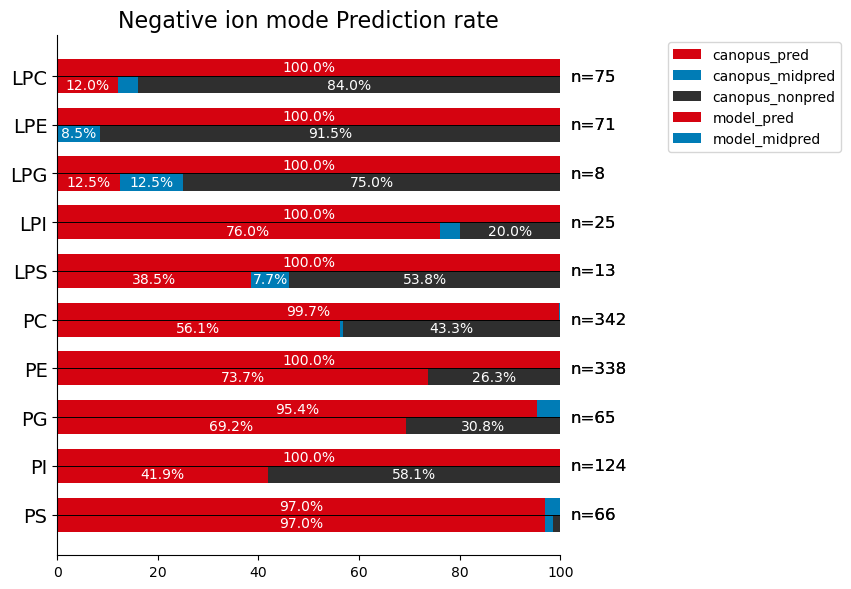

In [233]:
import matplotlib.pyplot as plt
import numpy as np

df_neg_cano = df_model_canopus_level5_s2_cano_resultratio.copy().sort_values('class')
df_neg_cano[['correct_pred','non_pred','mis_pred']] = df_neg_cano[['correct_pred','non_pred','mis_pred']] *100


df_neg_model =  df_model_canopus_level5_s2_model_resultratio.copy().sort_values('class')
df_neg_model[['correct_pred','mis_pred']] = df_neg_model[['correct_pred','mis_pred']] *100

# Create a bar chart for model data
fig, ax = plt.subplots(figsize=(9, 6))
width = 0.35  # Width of each bar

y = np.arange(len(df_neg_cano['class']))

red = '#d50310'
blue = '#007cb6'
black = '#2f2f2f'
custom_colors = [red, blue, black]

# Plot model_1st_correct and model_mispredict bars
ax.barh(y + width/2, df_neg_cano['correct_pred'], width, label='canopus_pred', color=custom_colors[0])
ax.barh(y + width/2, df_neg_cano['mis_pred'], width, label='canopus_midpred', color=custom_colors[1], left=df_neg_cano['correct_pred'])
ax.barh(y + width/2, df_neg_cano['non_pred'], width, label='canopus_nonpred', color=custom_colors[2], left=df_neg_cano['correct_pred']+df_neg_cano['mis_pred'])
ax.barh(y - width/2, df_neg_model['correct_pred'], width, label='model_pred', color=custom_colors[0])
ax.barh(y - width/2, df_neg_model['mis_pred'], width, label='model_midpred', color=custom_colors[1], left=df_neg_model['correct_pred'])

ax.set_ylabel('Class')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_title('Negative ion mode Prediction rate', fontsize=16)
ax.set_yticks(y)
ax.set_yticklabels(df_neg_cano['class'])
ax.legend(loc='upper left', bbox_to_anchor=(1.2, 1))

bars1= df_neg_cano[['correct_pred','mis_pred','non_pred']]
bars2= df_neg_model[['correct_pred','mis_pred']]

  
for n in bars1:
    for i, (cs, ab, pc, sn) in enumerate(zip(bars1.iloc[:, 0:].cumsum(1)[n],
                                          bars1[n], bars1[n],df_neg_cano.sort_values('class')['total_number'])):
        if pc > 5.0:  # 0.0% のとき表示しない
            plt.text(cs - ab / 2, i + width/2, str(np.round(pc, 1)) + '%',
                     va='center', ha='center', rotation=0, fontsize=10, c='white')
        plt.text(100 + 2, i, f'n={int(sn)}', va='center', ha='left', fontsize=12, alpha=0.8, c='black')

for n in bars2:
    for i, (cs, ab, pc) in enumerate(zip(bars2.iloc[:, 0:].cumsum(1)[n],
                                          bars2[n], bars2[n])):
        if pc > 5.0:  # 0.0% のとき表示しない
            plt.text(cs - ab / 2, i - width/2, str(np.round(pc, 1)) + '%',
                     va='center', ha='center', rotation=0, fontsize=10, c='white')
            

for i in range(len(df_neg_cano)):
    plt.axhline(i, color='black', linewidth=0.7)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.gca().invert_yaxis()
plt.yticks(size = 14)
plt.tight_layout()
plt.savefig('Data/svg/test/canopus/neg_canopus-vs-model_selectclass.svg', format='svg', dpi=300, bbox_inches='tight')
plt.show()